In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms.assortativity.mixing import (
    attribute_mixing_matrix,
    attribute_mixing_dict,
    degree_mixing_matrix,
)
import datetime
from collections import Counter
import seaborn as sns

In [2]:
#read in edge data
df = pd.read_csv("network.csv")
df["source"] = df["source"].astype(int)
df["target"] = df["target"].astype(int)

In [4]:
#read in node attributes
attribs = pd.read_csv("node_attributes.csv")
#convert dtype
attribs.loc[:, attribs.columns!="gender"] = attribs.drop(["gender"], axis=1).astype(int)

In [5]:
#create network
G = nx.from_pandas_edgelist(df[["source", "target"]], create_using=nx.DiGraph)
#add node attributes
for name in ["gender", "age", "post_count", "time_on_platform"]:
    nx.set_node_attributes(G, attribs[[name, "user_id"]].set_index("user_id").loc[:, name], name)

In [6]:
#drop nodes that do not have metadata
for node in list(G.nodes(data=True)):
    if len(node[1]) == 0:
        G.remove_node(node[0])

### Degree distributions

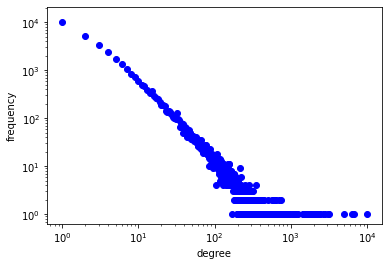

In [14]:
outdegree = Counter([i[1] for i in list(G.out_degree)])
for k, v in dict(outdegree).items():
    plt.scatter(x=k, y=v, c="blue")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("degree")
plt.savefig("outdegree")

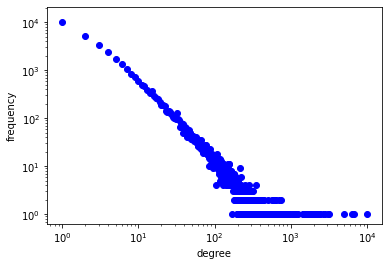

In [15]:
indegree = Counter([i[1] for i in list(G.in_degree)])
for k, v in dict(outdegree).items():
    plt.scatter(x=k, y=v, c="blue")
plt.xscale("log")
plt.yscale("log")
plt.ylabel("frequency")
plt.xlabel("degree")
plt.savefig("indegree")

### Basic network stats

In [9]:
nx.reciprocity(G)

0.5140726016496598

In [10]:
cc = nx.clustering(G)
sum(cc.values()) / len(cc)

0.11123065457223291

In [11]:
nx.density(G)

0.00026734803196402625

### Assortativity

In [23]:
#create random reference network
#this graph will have the same connection, but shuffled attributes
shuffled_G = G.copy()
shuffled_attribs = attribs.copy()
shuffled_attribs["user_id"] = shuffled_attribs["user_id"].sample(frac=1, random_state=1).reset_index(drop=True)
#add atributes to nodes
for name in ["gender", "age", "post_count", "time_on_platform"]:
    nx.set_node_attributes(shuffled_G, shuffled_attribs[[name, "user_id"]].set_index("user_id").loc[:, name], name)

In [24]:
#age assortativity
print(nx.numeric_assortativity_coefficient(G, "age"))
print(nx.numeric_assortativity_coefficient(shuffled_G, "age"))

0.04260778148482193
0.0003312440949745456


In [25]:
#time on platform assortativity
print(nx.numeric_assortativity_coefficient(G, "time_on_platform"))
print(nx.numeric_assortativity_coefficient(shuffled_G, "time_on_platform"))

0.3411679129570621
-0.00021532278363527223


In [26]:
#post count assortativity
print(nx.numeric_assortativity_coefficient(G, "post_count"))
print(nx.numeric_assortativity_coefficient(shuffled_G, "post_count"))

0.0028888804129231283
-0.002689531331603341


#### Gender assortativity

Text(0.5, 15.0, 'target')

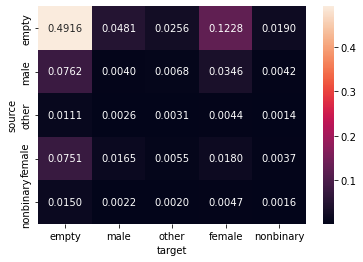

In [27]:
#sanity check that the matrix sums to 1
#print(pd.DataFrame(attribute_mixing_dict(G, attribute="gender", normalized=True)).sum().sum())
#raw frequencies for original graph
sns.heatmap(pd.DataFrame(attribute_mixing_dict(G, attribute="gender", normalized=True)).T, annot=True, fmt=".4f")
plt.ylabel("source")
plt.xlabel("target")

Text(0.5, 15.0, 'target')

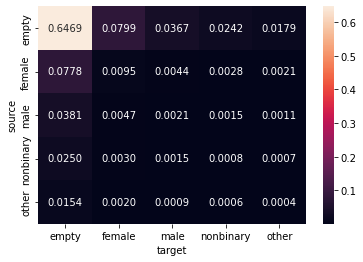

In [28]:
#sanity check that the matrix sums to 1
#print(pd.DataFrame(attribute_mixing_dict(shuffled_G, attribute="gender", normalized=True)).sum().sum())
#raw frequencies for shuffled graph
sns.heatmap(pd.DataFrame(attribute_mixing_dict(shuffled_G, attribute="gender", normalized=True)).T, annot=True, fmt=".4f")
plt.ylabel("source")
plt.xlabel("target")

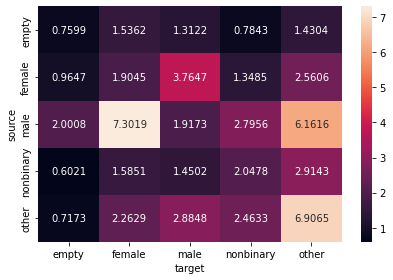

In [30]:
#normalized gender assortativity
sns.heatmap(pd.DataFrame(attribute_mixing_dict(G, attribute="gender", normalized=True)).T/pd.DataFrame(attribute_mixing_dict(shuffled_G, attribute="gender", normalized=True)).T, annot=True, fmt=".4f")
plt.ylabel("source")
plt.xlabel("target")
plt.tight_layout()
plt.savefig("gender_assortativity")

### Interaction graph

Decided not to use it in the report, since I only have posts from 750 people, so they are the only ones having incoming edges and it skews a lot. However, since I already wrote the code I will just drop it here

In [ ]:
#read in posts and comments
comments = pd.read_csv("comments")
posts = pd.read_csv("posts")

In [ ]:
#join comments onto posts
merged = posts.merge(comments, on="post_id", how="right")

In [ ]:
#transform it into a simple edgelist with connection count
interaction_df = merged[["user_id", "author"]].value_counts().reset_index()
interaction_df["user_id"] = interaction_df["user_id"].astype(int)
interaction_df["author"] = interaction_df["author"].astype(int)
interaction_df = interaction_df.rename(columns={0: "count"})
interaction_df["count"] = interaction_df["count"].astype(int)
#exclude self loops
interaction_df = interaction_df[interaction_df["author"]!=interaction_df["user_id"]]

In [ ]:
#create interaction graph
interaction_graph = nx.from_pandas_edgelist(interaction_df, source="author", target="user_id", edge_attr="count", create_using=nx.DiGraph)

In [ ]:
#add metadata to nodes
for name in ["gender", "age", "post_count", "time_on_platform"]:
    nx.set_node_attributes(interaction_graph, attribs[[name, "user_id"]].set_index("user_id").loc[:, name], name)

In [ ]:
#remove nodes with missing metadata
for node in list(interaction_graph.nodes(data=True)):
    if len(node[1]) == 0:
        interaction_graph.remove_node(node[0])

In [ ]:
#create reference random network
shuffled_interaction_graph = interaction_graph.copy()

In [ ]:
#add shuffled labels to random reference network
#we can reuse the shuffled attributes from earlier
for name in ["gender", "age", "post_count", "time_on_platform"]:
    nx.set_node_attributes(shuffled_interaction_graph, shuffled_attribs[[name, "user_id"]].set_index("user_id").loc[:, name], name)

In [ ]:
#modify nx's attribute mixing dict to account for edge weights
def weighted_mixing_dict(G, attribute="gender", normalized=False):
    d = {}
    psum = 0.0
    for u, v, attr in G.edges(data=True):
        x = G.nodes[u][attribute]
        y = G.nodes[v][attribute]
        if x not in d:
            d[x] = {}
        if y not in d:
            d[y] = {}
        val = d[x].get(y, 0)
        d[x][y] = val + attr["count"]
        psum += attr["count"]

    if normalized:
        for _, jdict in d.items():
            for j in jdict:
                jdict[j] /= psum
    return d

In [ ]:
#unweighted normalized gender assortativity
sns.heatmap(pd.DataFrame(attribute_mixing_dict(interaction_graph, attribute="gender", normalized=True)).T/pd.DataFrame(attribute_mixing_dict(shuffled_interaction_graph, attribute="gender", normalized=True)).T, annot=True, fmt=".4f")
plt.ylabel("source")
plt.xlabel("target")

In [ ]:
#weighted normalized gender assortativity
sns.heatmap(pd.DataFrame(weighted_mixing_dict(interaction_graph, attribute="gender", normalized=True)).T/pd.DataFrame(weighted_mixing_dict(shuffled_interaction_graph, attribute="gender", normalized=True)).T, annot=True, fmt=".4f")
plt.ylabel("source")
plt.xlabel("target")

##### Basic stats of interaction network

In [ ]:
print(nx.reciprocity(interaction_graph))

In [ ]:
print(nx.numeric_assortativity_coefficient(interaction_graph, "age"))
print(nx.numeric_assortativity_coefficient(shuffled_interaction_graph, "age"))

In [ ]:
print(nx.numeric_assortativity_coefficient(interaction_graph, "post_count"))
print(nx.numeric_assortativity_coefficient(shuffled_interaction_graph, "post_count"))

In [ ]:
print(nx.numeric_assortativity_coefficient(interaction_graph, "time_on_platform"))
print(nx.numeric_assortativity_coefficient(shuffled_interaction_graph, "time_on_platform"))

In [ ]:
outdegree = Counter([i[1] for i in list(interaction_graph.out_degree)])
for k, v in dict(outdegree).items():
    plt.scatter(x=k, y=v, c="blue")
#plt.xscale("log")
plt.yscale("log")

In [ ]:
indegree = Counter([i[1] for i in list(interaction_graph.in_degree)])
for k, v in dict(indegree).items():
    plt.scatter(x=k, y=v, c="blue")
#plt.xscale("log")
plt.yscale("log")